In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.optimizers import Adam
from keras.layers import Input, Dense, Dropout, concatenate, Embedding
from keras.models import Model
from keras import regularizers
from keras import backend as K 
from keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
# Use random seed
tf.random.set_seed(100)

In [3]:
""" import dataset """

df1 = pd.read_csv('ratings_5cluster.csv',usecols=['user_id','food_id', 'rating', 'cluster'])

In [4]:
""" number of clusters """
num_cluster = df1['cluster'].unique().max() + 1

In [5]:
items = pd.read_csv('food_nutrition_IQR15.csv',
                    usecols=['id', 'calories', 'total_fat', 'sugar', 'sodium', 'protein', 'saturated_fat',
                             'carbohydrates'] ,engine='python').rename(columns={"id": "food_id"})

In [6]:
'''merge rates with recipes nutrition dataset'''
df2 = pd.merge(df1,items)
df2

,user_id,food_id,rating,cluster,calories,total_fat,sugar,sodium,protein,saturated_fat,carbohydrates
0,56680,79222,5,0,274.2,12,15,18,32,22,12
1,101823,79222,5,0,274.2,12,15,18,32,22,12
2,446143,79222,4,0,274.2,12,15,18,32,22,12
3,226989,79222,4,1,274.2,12,15,18,32,22,12
4,868654,79222,5,1,274.2,12,15,18,32,22,12
...,...,...,...,...,...,...,...,...,...,...,...
113862,322548,146183,5,0,96.5,0,25,0,2,0,7
113863,841067,146183,1,4,96.5,0,25,0,2,0,7
113864,384210,146183,5,0,96.5,0,25,0,2,0,7
113865,260689,181229,5,0,257.6,29,30,36,13,45,5


In [7]:
""" Functions """

def dataPreprocessor(rating_df, num_users, num_items, init_value=0):
    """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
            num_row: int. number of items
            num_col: int. number of users
            
        OUTPUT:
            matrix: 2D numpy array. 
    """
    matrix = np.full((num_items, num_users), init_value)   #full empty matrix with 0's
    for (_, rating, userID, itemID) in rating_df.itertuples():
      matrix[itemID, userID] = rating                 #full empty matrix with rates

    return matrix

In [8]:
def show_error(history, skip):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot(np.arange(skip, len(loss), 1), loss[skip:])
    plt.plot(np.arange(skip, len(loss), 1), val_loss[skip:])
    plt.title('Cluster {}'.format(k))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()

In [9]:
def masked_mse(y_true, y_pred):
        # masked function
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1)
        return masked_mse

In [10]:
def masked_rmse(y_true, y_pred):
        # masked function (using only y_true values that not equal to zero)
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sqrt(K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1))
        return masked_mse

In [11]:
def masked_rmse_clip(y_true, y_pred):
        # masked function
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        y_pred = K.clip(y_pred, 1, 5)
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sqrt(K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1))
        return masked_mse

In [12]:
# Creating a custom function for MAE 
def masked_mae_clip(y_true, y_pred):
    mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
    y_pred = K.clip(y_pred, 1, 5)
    masked_abs_error = K.abs(mask_true * (y_true - y_pred))
    masked_mae = K.sum(masked_abs_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1)
    return masked_mae

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 UserRating (InputLayer)        [(None, 1105)]       0           []                               
                                                                                                  
 dropout_5 (Dropout)            (None, 1105)         0           ['UserRating[0][0]']             
                                                                                                  
 ItemInfo (InputLayer)          [(None, 7)]          0           []                               
                                                                                                  
 Concatenate (Concatenate)      (None, 1112)         0           ['dropout_5[0][0]',              
                                                                  'ItemInfo[0][0]']         

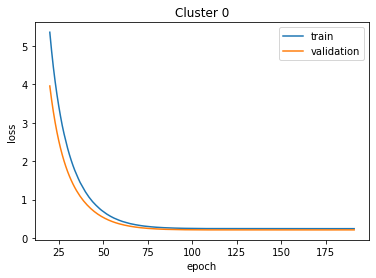

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 UserRating (InputLayer)        [(None, 1378)]       0           []                               
                                                                                                  
 dropout_6 (Dropout)            (None, 1378)         0           ['UserRating[0][0]']             
                                                                                                  
 ItemInfo (InputLayer)          [(None, 7)]          0           []                               
                                                                                                  
 Concatenate (Concatenate)      (None, 1385)         0           ['dropout_6[0][0]',              
                                                                  'ItemInfo[0][0]']         

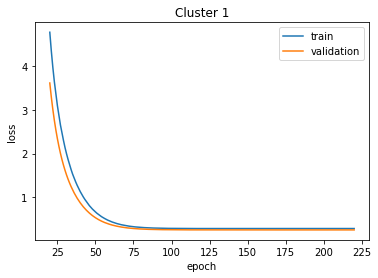

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 UserRating (InputLayer)        [(None, 310)]        0           []                               
                                                                                                  
 dropout_7 (Dropout)            (None, 310)          0           ['UserRating[0][0]']             
                                                                                                  
 ItemInfo (InputLayer)          [(None, 7)]          0           []                               
                                                                                                  
 Concatenate (Concatenate)      (None, 317)          0           ['dropout_7[0][0]',              
                                                                  'ItemInfo[0][0]']         

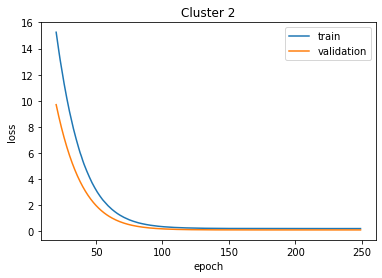

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 UserRating (InputLayer)        [(None, 184)]        0           []                               
                                                                                                  
 dropout_8 (Dropout)            (None, 184)          0           ['UserRating[0][0]']             
                                                                                                  
 ItemInfo (InputLayer)          [(None, 7)]          0           []                               
                                                                                                  
 Concatenate (Concatenate)      (None, 191)          0           ['dropout_8[0][0]',              
                                                                  'ItemInfo[0][0]']         

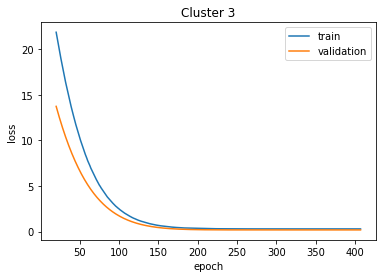

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 UserRating (InputLayer)        [(None, 878)]        0           []                               
                                                                                                  
 dropout_9 (Dropout)            (None, 878)          0           ['UserRating[0][0]']             
                                                                                                  
 ItemInfo (InputLayer)          [(None, 7)]          0           []                               
                                                                                                  
 Concatenate (Concatenate)      (None, 885)          0           ['dropout_9[0][0]',              
                                                                  'ItemInfo[0][0]']         

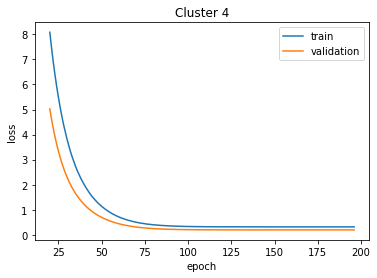

In [17]:
""" execute DAE """

#loop over clusters

RMSE_result = []
MAE_result = []


for k in range(num_cluster):
    #select rates of cluster k
    df3 = df2.loc[df2['cluster'] == k]
    df3['users_id'] = pd.factorize(df3.user_id)[0]
    df3['foods_id'] = pd.factorize(df3.food_id)[0]
    
    #remove unnessory columns
    df = df3.drop(['user_id', 'food_id', 'cluster'], axis=1)

    #+1 is the real size, as they are zero based
    num_users = df['users_id'].unique().max() + 1
    num_foods = df['foods_id'].unique().max() + 1
    
    #print("the number of items =", num_foods)
    
    side_info = df.drop(['rating', 'users_id'], axis=1).groupby(['foods_id']).first()
    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    d = scaler.fit_transform(side_info)
    side_info_norm = pd.DataFrame(d, columns=side_info.columns)
    side_info_np = side_info_norm.to_numpy()
    
    new_df = df.drop(['calories', 'total_fat', 'sugar', 'sodium', 'protein', 'saturated_fat',
                             'carbohydrates'], axis=1).sort_values(by=['foods_id'])

    #divide ds int trin and test sets
    train_df, test_df = train_test_split(new_df, test_size=0.2, random_state=100)  
    
    # Creating a sparse pivot table with items in rows and users in columns
    users_items_matrix_train_zero = dataPreprocessor(train_df, num_users, num_foods, 0)
    users_items_matrix_test = dataPreprocessor(test_df, num_users, num_foods, 0)
    

    #convert int array to float
    users_items_matrix_train_zero_float = users_items_matrix_train_zero.astype(float)
    users_items_matrix_test_float = users_items_matrix_test.astype(float)
    
    #build the model
    item = Input(shape=(side_info_np.shape[1]), name='ItemInfo')
    input_layer = x = Input(shape=(users_items_matrix_train_zero.shape[1],), name='UserRating')
    x1 = Dropout(rate = 0.5)(x)
    con = concatenate([x1, item], name='Concatenate')
    h = Dense(128, activation='sigmoid', name='LatentSpace', kernel_regularizer=regularizers.l2(0.1))(con)
    output_layer = Dense(users_items_matrix_train_zero.shape[1], activation='linear', name='UserScorePred')(h)
    Rec = Model([input_layer, item], output_layer)
    
    Rec.compile(optimizer = Adam(learning_rate=0.0001), loss=masked_mse, metrics=[masked_mae_clip, masked_rmse_clip])
    Rec.summary()

    #Run the model
    es = EarlyStopping(monitor='val_masked_rmse_clip', mode='min', verbose=0, patience=20)
    
    
    hist_Rec = Rec.fit(x=[users_items_matrix_train_zero_float, side_info_np], y=users_items_matrix_train_zero_float, 
                            epochs=500, batch_size=128, verbose = 0,  
                            validation_data=[[users_items_matrix_train_zero_float, side_info_np], 
                                             users_items_matrix_test_float], callbacks=[es])

    #Evaluate the model
    test_result_deep = Rec.evaluate([users_items_matrix_train_zero_float, side_info_np], users_items_matrix_test_float)
    
    show_error(hist_Rec, 20)

    #store the RMSE of each cluster
    RMSE_result.append(test_result_deep[2])
    
    MAE_result.append(test_result_deep[1])
    
    #save the model
    Rec.save_weights('models/model_c{}.h5'.format(k))

In [18]:
RMSE_result

[0.2678201496601105,
 0.3302212953567505,
 0.12371484935283661,
 0.13686102628707886,
 0.2245865911245346]

In [19]:
# find the average of RMSE
average = sum(RMSE_result) / len(RMSE_result)

# Printing average of the list
print("Average of RMSE =", round(average, 4))

Average of RMSE = 0.2166


In [20]:
# find the average of MAE
average = sum(MAE_result) / len(MAE_result)

# Printing average of the list
print("Average of MAE =", round(average, 4))

Average of MAE = 0.1949
